# SENG 550: NYC Taxi Data Analysis


**Contributors:**
* Maram Elsayed		(30071200)
* Mathew Pelletier 		(10103415)
* Marco Arias 			(30079108)
* Alexandra Glodzinski 	(30038541)



## Environment Setup

**Project library imports**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *

# Models Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


**Building Spark Session**

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Test")\
        .getOrCreate()
spark

**Defining Spark Context**

In [ ]:
sc = spark.sparkContext
sc

<SparkContext master=local appName=Test>

## Load and check the data

In [ ]:
df = spark.read.option("header",True) \
     .option("infer_schema", True) \
     .csv("trip_data/trip_data_1.csv")

df1 = spark.read.option("header",True) \
     .option("infer_schema", True) \
     .csv("trip_data/trip_fare_1.csv")

df.printSchema()
df.show(5)

df1.printSchema()

df1.show(5)

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_time_in_secs: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropo

## Preprocessing DataFrame

### (a) Removing unnecessary spaces from headers in df1 to match df
We have two datasets that we're joining into one DataFrame, unfortunately the feature headers (Labels) don't match because of unnecessary spaces, we're removing those spaces in order to be able to join DataFrames smoothly.

In [ ]:
df1 = df1.withColumnRenamed(" medallion","medallion") \
    .withColumnRenamed(" hack_license","hack_license") \
    .withColumnRenamed(" vendor_id","vendor_id") \
    .withColumnRenamed(" pickup_datetime","pickup_datetime") \
    .withColumnRenamed(" payment_type","payment_type") \
    .withColumnRenamed(" fare_amount","fare_amount") \
    .withColumnRenamed(" surcharge","surcharge") \
    .withColumnRenamed(" mta_tax","mta_tax") \
    .withColumnRenamed(" tip_amount","tip_amount") \
    .withColumnRenamed(" tolls_amount","tolls_amount") \
    .withColumnRenamed(" total_amount","total_amount") \

df1.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- surcharge: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- total_amount: string (nullable = true)



### (b) Joining df1 to df

This step is joining data from both DataFrames by the following fields: 'medallion', 'pickup_datetime', 'hack_license', and 'vendor_id'.

In [ ]:
df = df.join(df1, ['medallion','pickup_datetime', 'hack_license', 'vendor_id', ])
df.show()

+--------------------+-------------------+--------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|    pickup_datetime|        hack_license|vendor_id|rate_code|store_and_fwd_flag|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+-------------------+--------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|00005007A9F30E289...|2013-01-03 20:15:01|A

**Checking the schema to make sure it joined correctly and there are no duplicate fields**

In [ ]:
df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_time_in_secs: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- surcharge: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- total_amount: string (nullable = true)



### (c) Only use approximately 10 percent of data
Our dataset is fairly large (14 million rows) and due to its size, the execution time was significantly consuming. Therefore we had to cut down our data to only 10 percent. This was obtained by the following steps:


*   Assigning row numbers to column 'row'
*   Filtering rows by using row numbers divisible by 10



In [ ]:
df = df.select("*").withColumn("row", monotonically_increasing_id())

In [ ]:
df = df.filter(df.row%10 == 0)

In [ ]:
rows = df.count()
print(f"DataFrame Rows count : {rows}")

DataFrame Rows count : 1477663


### (d) Remove data that doesn't have type 1 for rate_code

We only want trips within the city, this can be obtained by only using trips with 'rate_code' as 1

In [ ]:
df = df.filter(df.rate_code == "1")
df.show()

+--------------------+-------------------+--------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+---+
|           medallion|    pickup_datetime|        hack_license|vendor_id|rate_code|store_and_fwd_flag|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|row|
+--------------------+-------------------+--------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+---+
|00005007A9F30E289...|2013-01-0

### (e) Filter out unwanted fields

In [ ]:
df = df.drop(*('medallion',
                'hack_license',
                'vendor_id',
                'rate_code',
                'store_and_fwd_flag',
                'dropoff_datetime',
                'passenger_count',
                'payment_type',
                'surcharge',
                'mta_tax',
                'tip_amount',
                'tolls_amount',
                'total_amount',
                'row'))
df.show()

+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+
|    pickup_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|fare_amount|
+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+
|2013-01-03 20:15:01|              421|         1.30|      -73.990501|      40.737629|       -74.005951|       40.735947|          7|
|2013-01-19 22:30:46|              845|         2.70|      -73.988625|      40.758896|       -74.007736|       40.735584|       11.5|
|2013-01-30 21:06:28|              264|         1.00|      -73.989304|      40.757877|       -73.977768|       40.764202|        5.5|
|2013-01-10 09:07:00|              360|         1.69|      -73.961273|      40.771461|       -73.961273|       40.771461|          7|
|2013-01-04 00:03:17|              273|          .60|      -73

### (f) Changing all string types to designated types

In [ ]:
df = df.withColumn("trip_time_in_secs",col("trip_time_in_secs").cast('integer')) \
    .withColumn("trip_distance",col("trip_distance").cast('double')) \
    .withColumn("pickup_longitude",col("pickup_longitude").cast('double')) \
    .withColumn("pickup_latitude",col("pickup_latitude").cast('double')) \
    .withColumn("dropoff_longitude",col("dropoff_longitude").cast('double')) \
    .withColumn("dropoff_latitude",col("dropoff_latitude").cast('double')) \
    .withColumn("fare_amount",col("fare_amount").cast('double'))

### (g) Removing Invalid Coordinates

In [ ]:
rows = df.count() # Row count before filtering
print(f"DataFrame Rows count : {rows}")

DataFrame Rows count : 1445739


In [ ]:
#Removing Longitude and Latitude values outside of zero values (0)
df = df.filter((df.pickup_longitude < -72.8) & (df.pickup_longitude > -74.5)
            & (df.pickup_latitude < 41.8) & (df.pickup_latitude > 40.5)
            & (df.dropoff_longitude < -72.8) & (df.dropoff_longitude > -74.5)
            & (df.dropoff_latitude < 41.8) & (df.dropoff_latitude > 40.5))
rows = df.count() # Row count after filtering
print(f"DataFrame Rows count after dropping invalid coordinates: {rows}") 
df.show()

DataFrame Rows count after dropping invalid coordinates: 1418802
+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+
|    pickup_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|fare_amount|
+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+
|2013-01-03 20:15:01|              421|          1.3|      -73.990501|      40.737629|       -74.005951|       40.735947|        7.0|
|2013-01-19 22:30:46|              845|          2.7|      -73.988625|      40.758896|       -74.007736|       40.735584|       11.5|
|2013-01-30 21:06:28|              264|          1.0|      -73.989304|      40.757877|       -73.977768|       40.764202|        5.5|
|2013-01-10 09:07:00|              360|         1.69|      -73.961273|      40.771461|       -73.961273|       40.771461|        7.

### (h) Separate pickup_datetime into day and time columns

In [ ]:
df1 = df.withColumn('date', split(df['pickup_datetime'], ' ').getItem(0)) \
       .withColumn('time', split(df['pickup_datetime'], ' ').getItem(1))
df1.show()

+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+----------+--------+
|    pickup_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|fare_amount|      date|    time|
+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+----------+--------+
|2013-01-03 20:15:01|              421|          1.3|      -73.990501|      40.737629|       -74.005951|       40.735947|        7.0|2013-01-03|20:15:01|
|2013-01-19 22:30:46|              845|          2.7|      -73.988625|      40.758896|       -74.007736|       40.735584|       11.5|2013-01-19|22:30:46|
|2013-01-30 21:06:28|              264|          1.0|      -73.989304|      40.757877|       -73.977768|       40.764202|        5.5|2013-01-30|21:06:28|
|2013-01-10 09:07:00|              360|         1.69|      -73.961273|      

**Turning 'date' from string to date format**

In [ ]:
df1 = df1.withColumn('formatted_date', to_date(unix_timestamp(col('date'), 'yyyy-MM-dd').cast("timestamp")))

df1.printSchema()

root
 |-- pickup_datetime: string (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- formatted_date: date (nullable = true)



**Creating a 'day_of_week' column where certain days of week correspond to numbers**

+  Sunday: 1
+  Monday: 2
+  Tuesday: 3
+  Wednesday: 4
+  Thursday: 5
+  Friday: 6
+  Saturday: 7

In [ ]:
df1 = df1.withColumn('day_of_week',dayofweek(df1.formatted_date))
df1.show()

+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+----------+--------+--------------+-----------+
|    pickup_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|fare_amount|      date|    time|formatted_date|day_of_week|
+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+----------+--------+--------------+-----------+
|2013-01-03 20:15:01|              421|          1.3|      -73.990501|      40.737629|       -74.005951|       40.735947|        7.0|2013-01-03|20:15:01|    2013-01-03|          5|
|2013-01-19 22:30:46|              845|          2.7|      -73.988625|      40.758896|       -74.007736|       40.735584|       11.5|2013-01-19|22:30:46|    2013-01-19|          7|
|2013-01-30 21:06:28|              264|          1.0|      -73.989304|      40.757877|       -7

**Extracting hours of the day from 'time' column and adding it to column 'hour'**

In [ ]:
df1 = df1.withColumn("hour", split(df1['time'], ':').getItem(0))
df1 = df1.withColumn("hour",col("hour").cast('integer'))
df1.printSchema()

root
 |-- pickup_datetime: string (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- formatted_date: date (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)



**Getting rid of unwanted columns**

In [ ]:
df1 = df1.drop(*('pickup_datetime',
                'date',
                'time',
                'formatted_date',
                'timestamp'))
df1.show()

+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+-----------+----+
|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|fare_amount|day_of_week|hour|
+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------+-----------+----+
|              421|          1.3|      -73.990501|      40.737629|       -74.005951|       40.735947|        7.0|          5|  20|
|              845|          2.7|      -73.988625|      40.758896|       -74.007736|       40.735584|       11.5|          7|  22|
|              264|          1.0|      -73.989304|      40.757877|       -73.977768|       40.764202|        5.5|          4|  21|
|              360|         1.69|      -73.961273|      40.771461|       -73.961273|       40.771461|        7.0|          5|   9|
|              273|          0.6|      -73.985161|      40.747807|       -73.977562

### (i) Removing trips below a minute and distance of 0 value

In [ ]:
df1 = df1.filter((df1.trip_time_in_secs >= 60) & (df1.trip_distance != 0))

### (j) Assigning blocks
This process takes trip coordinates and assigns city blocks depending on the longitude and latitude of the location.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def assignBlock(longitude, latitude):
    row = 100
    column = 100
    minLongitude = -73.97720629610636
    minLatitude = 40.500087
    maxLongitude = -72.816665
    maxLatitude = 41.8

    totalLongitude = maxLongitude - minLongitude
    totalLatitude = maxLatitude - minLatitude
        
    assignedRow = 0
    assignedColumn = 0

    blockLength = totalLongitude/row 

    blockHeight = totalLatitude/column

    for i in range(row):
        if (longitude - minLongitude) > (blockLength * i):
            assignedRow = i

    for j in range(column):
        if (latitude - minLatitude) > (blockHeight * j):
            assignedColumn = j

    return (assignedRow*(column+1)) + assignedColumn


my_udf = udf(assignBlock, IntegerType())

df1 = df1.withColumn("pickup_block", my_udf("pickup_longitude","pickup_latitude"))
df1 = df1.withColumn("dropoff_block", my_udf("dropoff_longitude","dropoff_latitude"))

**Getting rid of unnecessary data**

In [ ]:
df1 = df1.drop(*("pickup_longitude",
                "pickup_latitude",
                "dropoff_longitude",
                "dropoff_latitude"))
df1.show()

+-----------------+-------------+-----------+-----------+----+------------+-------------+
|trip_time_in_secs|trip_distance|fare_amount|day_of_week|hour|pickup_block|dropoff_block|
+-----------------+-------------+-----------+-----------+----+------------+-------------+
|              421|          1.3|        7.0|          5|  20|          18|           18|
|              845|          2.7|       11.5|          7|  22|          19|           18|
|              264|          1.0|        5.5|          4|  21|          19|           20|
|              360|         1.69|        7.0|          5|   9|         121|          121|
|              273|          0.6|        5.0|          6|   0|          19|           19|
|              937|          9.0|       26.0|          1|  21|         929|           18|
|              751|          4.3|       15.0|          6|   9|          19|           16|
|              870|          4.4|       15.5|          5|   6|         422|          223|
|         

## Exploratory Data Analysis

### (a) Schema of PySpark DataFrame

In [ ]:
df1.printSchema()

root
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- pickup_block: integer (nullable = true)
 |-- dropoff_block: integer (nullable = true)



### (b) Showing First five rows of the PySpark DataFrame

In [ ]:
df1.show(5)

+-----------------+-------------+-----------+-----------+----+------------+-------------+
|trip_time_in_secs|trip_distance|fare_amount|day_of_week|hour|pickup_block|dropoff_block|
+-----------------+-------------+-----------+-----------+----+------------+-------------+
|              421|          1.3|        7.0|          5|  20|          18|           18|
|              845|          2.7|       11.5|          7|  22|          19|           18|
|              264|          1.0|        5.5|          4|  21|          19|           20|
|              360|         1.69|        7.0|          5|   9|         121|          121|
|              273|          0.6|        5.0|          6|   0|          19|           19|
+-----------------+-------------+-----------+-----------+----+------------+-------------+
only showing top 5 rows



### (c) Printing the shape of our PySpark DataFrame

In [ ]:
print(df1.count(),",",len(df1.columns))

1413131 , 7


### (d) Statistical Properties of the PySpark DataFrame

In [ ]:
df1.describe(['trip_time_in_secs']).show()
df1.describe(['trip_distance']).show()
df1.describe(['pickup_block']).show()
df1.describe(['dropoff_block']).show()
df1.describe(['fare_amount']).show()
df1.describe(['day_of_week']).show()
df1.describe(['hour']).show()

+-------+-----------------+
|summary|trip_time_in_secs|
+-------+-----------------+
|  count|          1413131|
|   mean|660.6246618324841|
| stddev|440.2157724211737|
|    min|               60|
|    max|            10320|
+-------+-----------------+

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|           1413131|
|   mean|2.5373506773257386|
| stddev| 2.643096936759867|
|    min|              0.01|
|    max|              99.6|
+-------+------------------+

+-------+------------------+
|summary|      pickup_block|
+-------+------------------+
|  count|           1413131|
|   mean| 77.20364283283008|
| stddev|194.51102741689604|
|    min|                 0|
|    max|              7593|
+-------+------------------+

+-------+-----------------+
|summary|    dropoff_block|
+-------+-----------------+
|  count|          1413131|
|   mean|83.66477771699864|
| stddev|185.0035808524852|
|    min|                0|
|    max|             9615|

### (e) Visualizing Frequency of 'day_of_week' and 'hour' to look at trends

In [ ]:
df_day = df1.cube("day_of_week").count()

df_day = df_day.dropna() # cube returns a duplicate null for each day of week

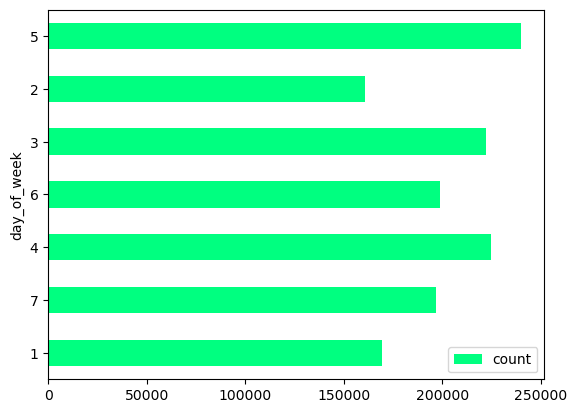

In [ ]:
pd_day = df_day.toPandas()
pd_day.plot(kind='barh', x='day_of_week', y='count', colormap='winter_r')
plt.show()

In [ ]:
df_hour = df1.cube("hour").count()

df_hour = df_hour.dropna() # cube returns a duplicate null for each hour

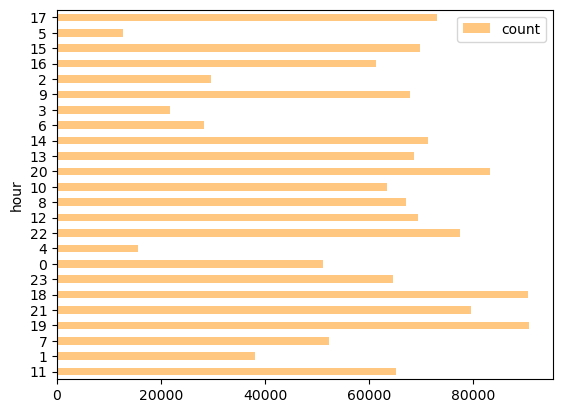

In [ ]:
pd_hour = df_hour.toPandas()
pd_hour.plot(kind='barh', x='hour', y='count', colormap='copper_r')
plt.show()

## Building Model

### (a) Feature Scaling

In [ ]:
df2 = df1.toPandas()
X = df2.drop(['trip_time_in_secs','fare_amount'], axis = 1)
print('shape of X: ', X.shape)

Y1 = df2['trip_time_in_secs']
print('shape of Y1: ', Y1.shape)

Y2 = df2['fare_amount']
print('shape of Y2: ', Y2.shape)

# Since we have 2 differenet predictions, we need to create two different Y sets for Trip Time 
# and for Trip Fare

scaler = StandardScaler() # Using standard scaler to scale our features
X = scaler.fit_transform(X)

shape of X:  (1413131, 5)
shape of Y1:  (1413131,)
shape of Y2:  (1413131,)


### (b) Building Model for Predicting Trip Time (in seconds)

**(b1) We will be splitting our Train and Test sets by 75% and 25% respectively.**

In [ ]:
model = LinearRegression()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y1, test_size=0.25, random_state=0)

clf = model.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

**(b2) Reporting Scores**

In [ ]:
print('Model Train Accuracy (score):', model.score(X_train, Y_train))
print('Model Test Accuracy (score):', model.score(X_test, Y_test))
print('Mean Absolute Error:', mean_absolute_error(Y_test, Y_predict))  
print('Mean Squared Error:', mean_squared_error(Y_test, Y_predict))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, Y_predict)))
print('R2:',r2_score(Y_test, Y_predict))

Model Train Accuracy (score): 0.5765169328187789
Model Test Accuracy (score): 0.570103382353824
Mean Absolute Error: 193.47521933592964
Mean Squared Error: 83525.65859333686
Root Mean Squared Error: 289.00805973767734
R2: 0.570103382353824


**(b3) Visualizing Results**

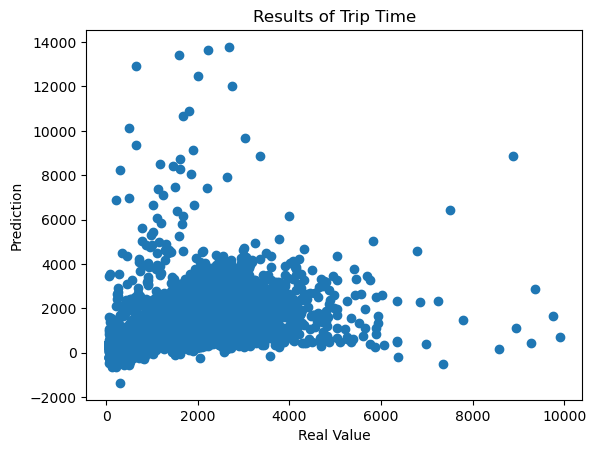

In [ ]:
plt.scatter(Y_test, Y_predict)
plt.title("Results of Trip Time")
plt.xlabel("Real Value")
plt.ylabel("Prediction")
plt.show()

### (c) Building Model for Predicting Trip Fare

**(c1) We will be splitting our Train and Test sets by 75% and 25% respectively.**

In [ ]:
# Using the same Linear Regression model defined in section (b1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y2, test_size=0.25, random_state=0)

clf = model.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

**(c2) Reporting Scores**

In [ ]:
print('Model Train Accuracy (score):', model.score(X_train, Y_train))
print('Model Test Accuracy (score):', model.score(X_test, Y_test))
print('Mean Absolute Error:', mean_absolute_error(Y_test, Y_predict))  
print('Mean Squared Error:', mean_squared_error(Y_test, Y_predict))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, Y_predict)))
print('R2:',r2_score(Y_test, Y_predict))

Model Train Accuracy (score): 0.8713617870581278
Model Test Accuracy (score): 0.8684295807308419
Mean Absolute Error: 1.2825764309139926
Mean Squared Error: 6.818901423691352
Root Mean Squared Error: 2.6113026296642357
R2: 0.8684295807308419


**(c3) Visualizing Results**

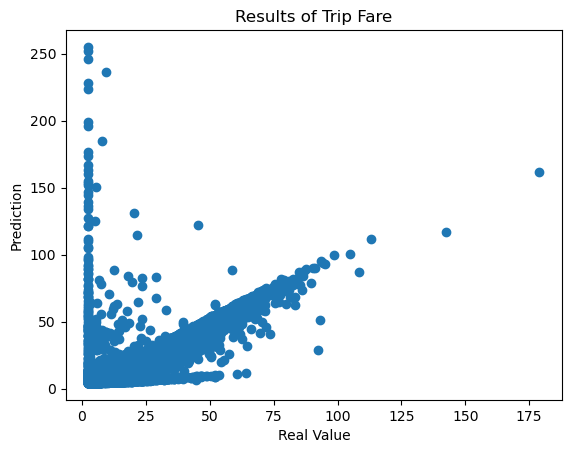

In [ ]:
plt.scatter(Y_test, Y_predict)
plt.title("Results of Trip Fare")
plt.xlabel("Real Value")
plt.ylabel("Prediction")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=515b00f4-74b9-4ef1-bb9c-ca95866a3996' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>